# Background

Inspired by my analysis of Miami Lakes Rboom data to measure the pressure pulse from the Tonga eruption an beamform back to the source, I began drinking in global barometric and infrasound data from IRIS (and Shake.net). Steve then took my measurements and began collating a table of reduced pressure versus other eruptions. This then mainfested an invite from Zhigang Peng to collaborate on a Tonga paper to look at all waves emanating from this eruption.

While I am focusing on that paper currently, this notebook has lots of earlier work, and will later be expanded for my own conference and journal papers (and one I am co-authoring with Steve).

Glenn Thompson, Jan - Feb 2022

# 1. Startup

## 1.1 Functions and imports

In [1]:
import os, sys, obspy, pickle, datetime
import pandas as pd
import matplotlib.pyplot as plt
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
import libTonga

## 1.2 Reload modules as needed

In [2]:
import importlib
importlib.reload(libTonga)

<module 'libTonga' from '/Users/thompsong/src/kitchensinkGT/LIB/libTonga.py'>

# 2. New functions

In [2]:
from obspy.clients.fdsn import Client
import numpy as np
def get_raw_data(fdsnURL, chanstring, startt, endt, lat=libTonga.sourcelat, lon=libTonga.sourcelon, fmin=0.001, network='*', station='*', \
                location='*', searchRadiusDeg=180.0):
    # raw stream and inventory - note that stationXML and Miniseed files are written if they do not exist already
    this_stream, this_inventory = libTonga.get_inventory_and_waveforms(fdsnURL, searchRadiusDeg, lat, \
                lon, startt, endt, chanstring, libTonga.DATA_ROOT, network=network, station=station, \
                location=location, overwrite=False)
    return this_stream, this_inventory

def reconstitute_raw_data(this_stream, this_inventory, reconfile): #chanstring, prepend):    
    # reconstituted Stream
    #T = np.round(1/fmin,0)
    #reconfile = os.path.join(libTonga.DATA_ROOT, 'MINISEED', '%s%s_reconstituted_%.0f.mseed' % (prepend, chanstring, T))
    this_reconstituted = obspy.Stream()
    if os.path.exists(reconfile):
        choice = input('%s exists. Load this (y/n)? Otherwise data will be reconstituted and saved over this' % reconfile)
        if choice[0].lower() == 'y':
            this_reconstituted = obspy.read(reconfile)
    if len(this_reconstituted)==0:
        this_reconstituted = libTonga.reconstitute_stream(this_stream, this_inventory, fmin=fmin)
        this_reconstituted.write(reconfile, format='PICKLE')
    return this_reconstituted
        
def filter_out_bad_traces(this_reconstituted, this_inventory, goodpklfile):
    good_ids_pickle = os.path.join(libTonga.DATA_ROOT, 'PICKLE', '%sgood_%s_ids_within_%.0f_degrees.pkl' % (prepend, chanstring, searchRadiusDeg))
    if os.path.exists(good_ids_pickle):
        with open(good_ids_pickle, 'rb') as f:
            good_ids = pickle.load(f)
        this_good = select_previously_manually_selected_traces(this_reconstituted, good_ids)
    else:
        this_good = obspy.Stream()
        if os.path.exists(goodpklfile):
            choice = input('%s exists. Load this (y/n)? Otherwise you have to manually pick traces and overwrite existing file' % goodmseedfile)
            if choice[0].lower() == 'y':
                this_good = obspy.read(goodpklfile)
        if len(this_good)==0:
            this_good = manually_select_good_traces(this_reconstituted)
            good_ids = []
            for tr in this_good:
                good_ids.append(tr.id)
            with open(good_ids_pickle, 'wb') as f:
                pickle.dump(good_ids, f)
            this_good.write(goodpklfile, format='PICKLE')
    print('Good traces saved as %s ' % goodpklfile)

    good_inv = subset_inv(this_inventory, this_stream, this_good)
    #plot_inv(good_inv)

    return this_good, good_inv

def enhance_stream(st, inv, lat=libTonga.sourcelat, lon=libTonga.sourcelon):
    st = libTonga.smart_merge(st)
    libTonga.attach_station_coordinates_from_inventory(inv, st)
    libTonga.attach_distance_to_stream(st, lat, lon)
    return st
    
def load_data_by_chanstring(chanstring, searchRadiusDeg, fmin, startt, endt, fdsnURL, \
                            select_good_channels=False):
    prepend = libTonga.get_fdsn_identifier(fdsnURL)
    # Files names like st_$CHANSTRING_$SEARCHRADIUSDEG_$FMIN.pkl (or _raw.pkl for data not reconstituted)
    rawmseedfile = os.path.join(libTonga.DATA_ROOT, 'MINISEED', '%s%s_within_%.0f_degrees.mseed' % (prepend, chanstring, searchRadiusDeg))
    rawxmlfile = os.path.join(libTonga.DATA_ROOT, 'STATIONXML', '%s%s_within_%.0f_degrees.xml' % (prepend, chanstring, searchRadiusDeg))
    reconpklfile = os.path.join(libTonga.DATA_ROOT, 'PICKLE', '%s%s_within_%.0f_degrees_%f.pkl' % (prepend, chanstring, searchRadiusDeg, fmin))
    goodpklfile = os.path.join(libTonga.DATA_ROOT, 'PICKLE', '%s%s_within_%.0f_degrees_%f_good.pkl' % (prepend, chanstring, searchRadiusDeg, fmin))
    goodxmlfile = os.path.join(libTonga.DATA_ROOT, 'STATIONXML', '%s%s_within_%.0f_degrees_%f_good.mseed' % (prepend, chanstring, searchRadiusDeg, fmin))

    # get correct Inventory
    if os.path.isfile(rawxmlfile):
        raw_inv = obspy.read_inventory(rawxmlfile)
        inv = raw_inv
    if select_good_channels:
        pklfile = goodpklfile
        if os.path.isfile(goodxmlfile):
            inv = obspy.read_inventory(goodxmlfile)        
    else:
        pklfile = reconpklfile

    # get correct Stream    
    if os.path.isfile(pklfile): 
        print('Loading %s\n(which we think is already reconstituted)' % pklfile)
        with open(pklfile, 'rb') as f:
            st = pickle.load(f)
        print('Enhancing')   
        enhanced_st = enhance_stream(st, raw_inv)    
        return enhanced_st, inv
    
    elif os.path.isfile(rawmseedfile): 
        print('Reading %s' % rawmseedfile)
        raw_st = obspy.read(rawmseedfile)
        print('Enhancing')
        enhanced_raw_st = enhance_stream(raw_st, raw_inv)
        print('Reconstituting')
        recon_st = reconstitute_raw_data(enhanced_raw_st, inv, reconpklfile)  
    else:
        raw_st, raw_inv = get_raw_data(fdsnURL, 
            chanstring, startt, endt, fmin=fmin, searchRadiusDeg=searchRadiusDeg)
        print('Enhancing')
        enhanced_raw_st = enhance_stream(raw_st, raw_inv)
        print('Reconstituting')
        recon_st = reconstitute_raw_data(raw_st, raw_inv, reconpklfile) 
        
    if select_good_channels:
        print('Filtering out bad traces')
        good_st, good_inv = filter_out_bad_traces(recon_st, raw_inv)
        return good_st, good_inv 
    else:
        return recon_st, raw_inv

# 3. Load 1 Hz data

## 3.1 Barometric and infrasound data

In [46]:
chanstring = 'LDO'
fmin_infrasound = 0.0001
searchRadiusDeg_1Hz = 180
fdsnURL = "http://service.iris.edu"
startt_1Hz =  obspy.core.UTCDateTime('2022-01-13T00:00:00.000000Z') - (1.0/fmin_infrasound)*2
endt_1Hz = obspy.core.UTCDateTime('2022-01-20T00:00:00.000000Z') - (1.0/fmin_infrasound)*2

In [5]:
st_ldo, inv_ldo = load_data_by_chanstring('LDO', searchRadiusDeg_1Hz, fmin_infrasound, startt_1Hz, \
                        endt_1Hz, fdsnURL, select_good_channels=False)

Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_LDO_within_180_degrees_0.000100.pkl
(which we think is already reconstituted)
Enhancing


In [6]:
st_ldf, inv_ldf = load_data_by_chanstring('LDF', searchRadiusDeg_1Hz, fmin_infrasound, startt_1Hz, \
                        endt_1Hz, fdsnURL, select_good_channels=False)

Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_LDF_within_180_degrees_0.000100.pkl
(which we think is already reconstituted)
Enhancing


In [7]:
# Raspberry Boom data - previously corrected
import glob
filepattern = os.path.join(libTonga.DATA_ROOT, 'MINISEED', 'corrected.AM.*.HDF.mseed')
rboompklfile = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'corrected.AM.HDF.pkl')
st_rboom = obspy.Stream()
for thisfile in glob.glob(filepattern):
    print(thisfile)
    st = obspy.read(thisfile)
    st.merge()
    for tr in st:
        print(tr)
        st_rboom.append(tr)
st_rboom.write(rboompklfile, 'PICKLE')

/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R3F75.HDF.mseed
AM.R3F75.00.HDF | 2022-01-15T15:34:44.196000Z - 2022-01-15T21:18:39.716000Z | 3.1 Hz, 64487 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R4B63.HDF.mseed
AM.R4B63.00.HDF | 2022-01-15T10:43:49.058999Z - 2022-01-15T15:10:09.858999Z | 3.1 Hz, 49941 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R44DC.HDF.mseed
AM.R44DC.00.HDF | 2022-01-15T16:00:58.059000Z - 2022-01-15T21:51:53.419000Z | 3.1 Hz, 65799 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.RC59E.HDF.mseed
AM.RC59E.00.HDF | 2022-01-15T16:00:12.265000Z - 2022-01-15T21:50:55.465000Z | 3.1 Hz, 65761 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R13D2.HDF.mseed
AM.R13D2.00.HDF | 2022-01-15T12:39:09.156999Z - 2022-01-15T17:36:15.396999Z | 3.1 Hz, 55708 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R94AB.HDF.mseed
AM.R94AB.00.HDF | 2022-01-15T10:45:56.389999Z - 2022-01-15T15:12:51.429999

AM.RAF39.00.HDF | 2022-01-15T13:45:24.727000Z - 2022-01-15T19:00:11.127000Z | 3.1 Hz, 59021 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R438F.HDF.mseed
AM.R438F.00.HDF | 2022-01-15T16:04:36.468999Z - 2022-01-15T21:56:30.068999Z | 3.1 Hz, 65981 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.S89A5.HDF.mseed
AM.S89A5.00.HDF | 2022-01-15T10:23:21.958999Z - 2022-01-15T14:44:15.718999Z | 3.1 Hz, 48919 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.RC93C.HDF.mseed
AM.RC93C.00.HDF | 2022-01-15T11:07:27.371999Z - 2022-01-15T15:40:06.411999Z | 3.1 Hz, 51123 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R08DA.HDF.mseed
AM.R08DA.00.HDF | 2022-01-15T12:17:21.553000Z - 2022-01-15T17:08:38.993000Z | 3.1 Hz, 54618 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R9606.HDF.mseed
AM.R9606.00.HDF | 2022-01-15T06:18:58.227999Z - 2022-01-15T09:34:41.587999Z | 3.1 Hz, 36699 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/cor

AM.RC1DA.00.HDF | 2022-01-15T16:31:26.037000Z - 2022-01-15T22:30:28.757000Z | 3.1 Hz, 67322 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.RA538.HDF.mseed
AM.RA538.00.HDF | 2022-01-15T16:39:11.910000Z - 2022-01-15T22:40:18.790000Z | 3.1 Hz, 67710 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R5419.HDF.mseed
AM.R5419.00.HDF | 2022-01-15T11:15:43.148000Z - 2022-01-15T15:50:34.348000Z | 3.1 Hz, 51536 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.RB3C2.HDF.mseed
AM.RB3C2.00.HDF | 2022-01-15T13:43:41.768000Z - 2022-01-15T18:58:00.648000Z | 3.1 Hz, 58935 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.RBE98.HDF.mseed
AM.RBE98.00.HDF | 2022-01-15T13:18:46.558999Z - 2022-01-15T18:26:26.718999Z | 3.1 Hz, 57689 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/corrected.AM.R9CDF.HDF.mseed
AM.R9CDF.00.HDF | 2022-01-15T07:35:47.401000Z - 2022-01-15T11:11:59.881000Z | 3.1 Hz, 40540 samples
/Users/thompsong/DATA/HungaTonga/MINISEED/cor

## 3.2 Seismic data

In [8]:
searchRadiusDeg_1Hz_seismic = 30
st_lh, inv_lh = load_data_by_chanstring('LH?', searchRadiusDeg_1Hz_seismic, fmin, startt, endt, fdsnURL, \
                            select_good_channels=False)

NameError: name 'fmin' is not defined

# 4. Load high sample rate data

## 4.1 Higher frequency infrasound data

In [47]:
searchRadiusDeg_50Hz_infrasound = 80
c_infrasound = 300
meters_per_degree = 1.11e5
startt_infrasound_high =  obspy.core.UTCDateTime('2022-01-15T03:45:00.000000Z') 
endt_infrasound_high = startt_infrasound_high + searchRadiusDeg_50Hz_infrasound * meters_per_degree/c_infrasound + 10800
st_baro_medium, inv_baro_medium = load_data_by_chanstring('BDO', searchRadiusDeg_50Hz_infrasound, fmin_infrasound, startt_infrasound_high, \
                    endt_infrasound_high, fdsnURL, select_good_channels=False)
st_infra_medium, inv_baro_medium = load_data_by_chanstring('BDF', searchRadiusDeg_50Hz_infrasound, fmin_infrasound, startt_infrasound_high, \
                    endt_infrasound_high, fdsnURL, select_good_channels=False)
st_baro_high, inv_baro_high = load_data_by_chanstring('HDO', searchRadiusDeg_50Hz_infrasound, fmin_infrasound, startt_infrasound_high, \
                    endt_infrasound_high, fdsnURL, select_good_channels=False)
st_infra_high, inv_baro_high = load_data_by_chanstring('HDF', searchRadiusDeg_50Hz_infrasound, fmin_infrasound, startt_infrasound_high, \
                    endt_infrasound_high, fdsnURL, select_good_channels=False)

Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_BDO_within_80_degrees_0.000100.pkl
(which we think is already reconstituted)
Enhancing
Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_BDF_within_80_degrees_0.000100.pkl
(which we think is already reconstituted)
Enhancing
Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_HDO_within_80_degrees_0.000100.pkl
(which we think is already reconstituted)
Enhancing
Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_HDF_within_80_degrees_0.000100.pkl
(which we think is already reconstituted)
Enhancing


In [51]:
st_infra = st_infra_medium + st_infra_high

In [52]:
#libTonga.attach_station_coordinates_from_inventory(inv_bdf, st_bdf)
#libTonga.attach_distance_to_stream(st_bdf, libTonga.sourcelat, libTonga.sourcelon)
r = np.array(libTonga.get_distance_vector(st_infra))
st_infra_o = libTonga.order_traces_by_distance(st_infra, r)

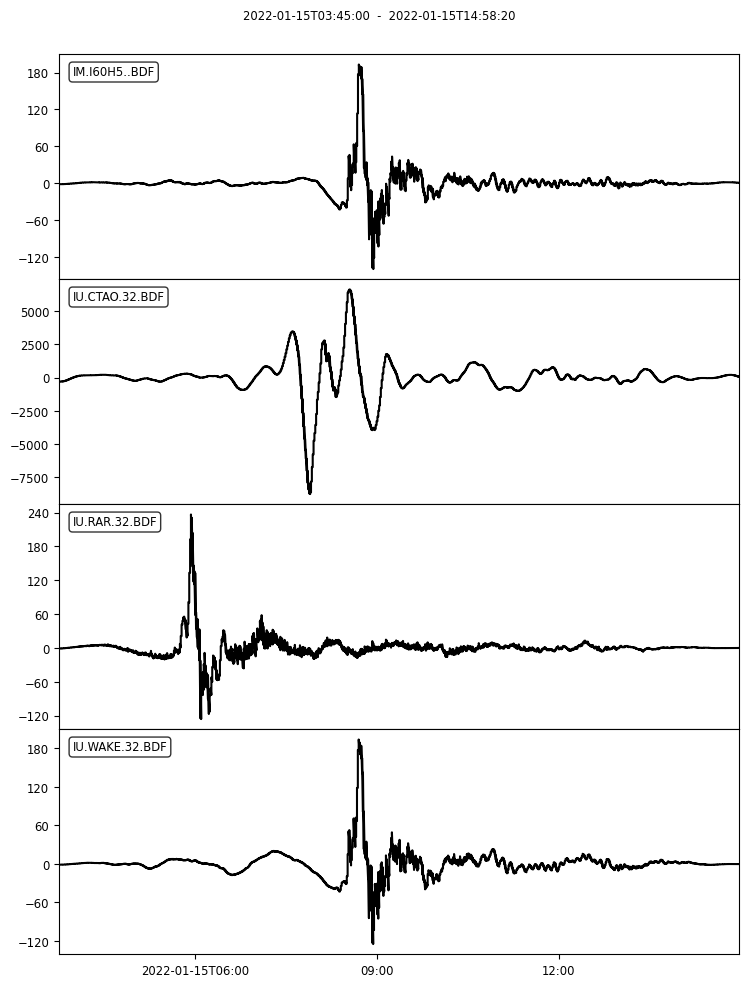

In [55]:
st_infra_o[0:4].plot(equal_scale=False);
v = 340
stime = obspy.UTCDateTime(2022,1,15,4,10,0)
etime = obspy.UTCDateTime(2022,1,15,4,20,0)
rar = st_bdf2[0].copy()
rar.stats.starttime -= rar.stats.distance/v
rar.plot(equal_scale=False, starttime=stime, endtime=etime );
rar.filter('highpass', freq=0.1, corners=2)
rar.plot(equal_scale=False, starttime=stime, endtime=etime );

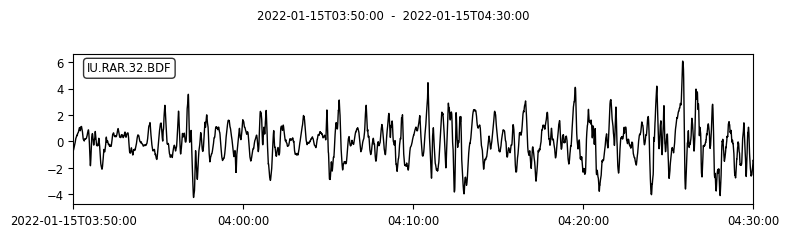

IU.RAR.32.BDF 1622781.19439


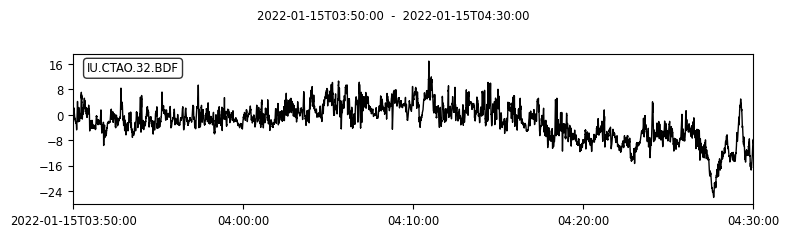

IU.CTAO.32.BDF 3991963.33265


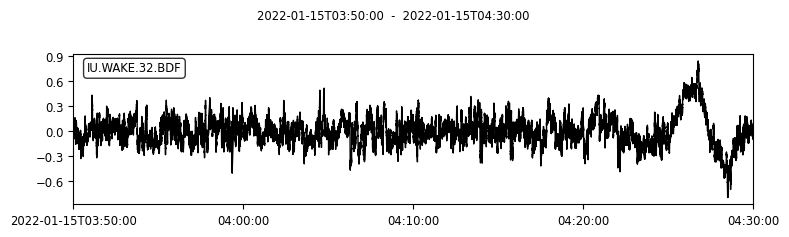

IU.WAKE.32.BDF 4840749.84572


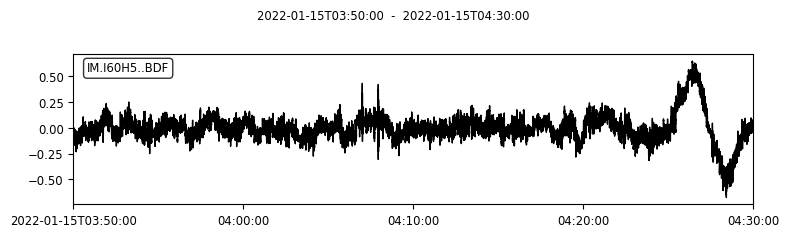

IM.I60H5..BDF 4843103.79787


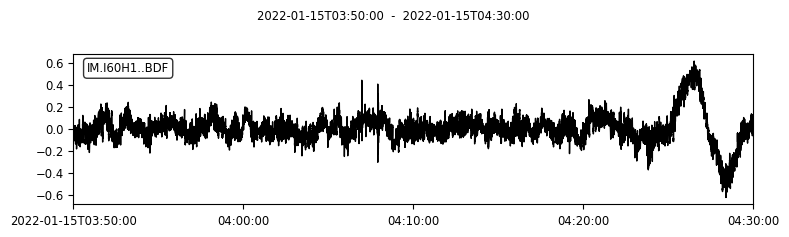

IM.I60H1..BDF 4843388.53926


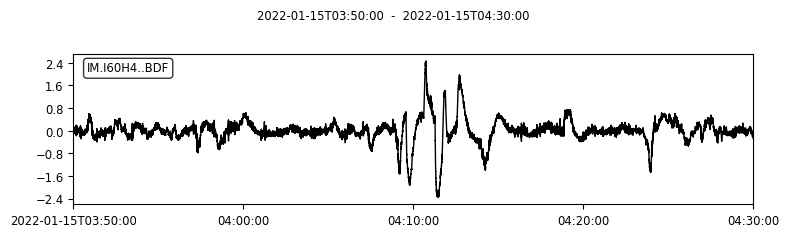

IM.I60H4..BDF 4843443.59776


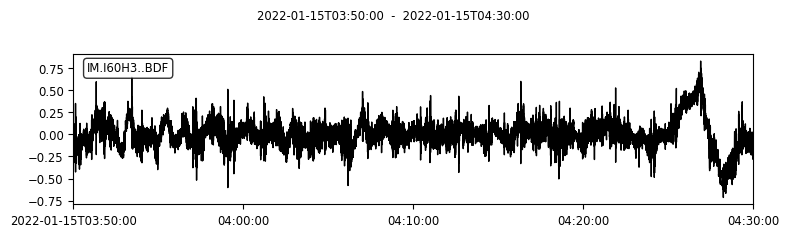

IM.I60H3..BDF 4843834.68185


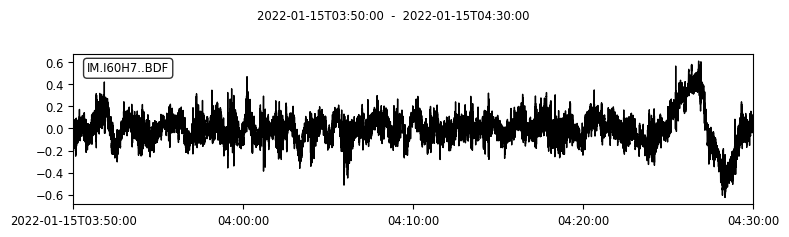

IM.I60H7..BDF 4844097.98307


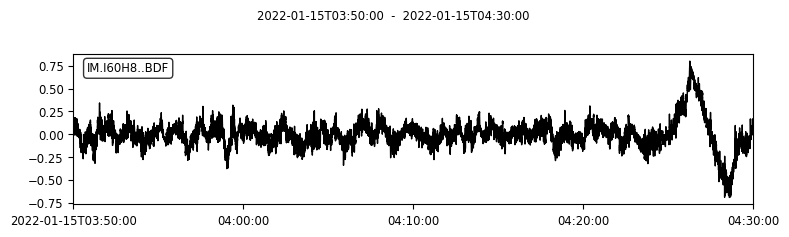

IM.I60H8..BDF 4844210.19783


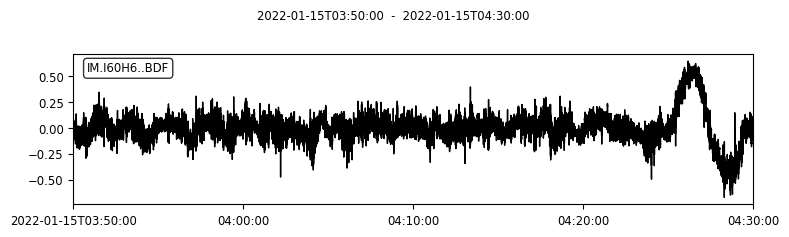

IM.I60H6..BDF 4844452.96489


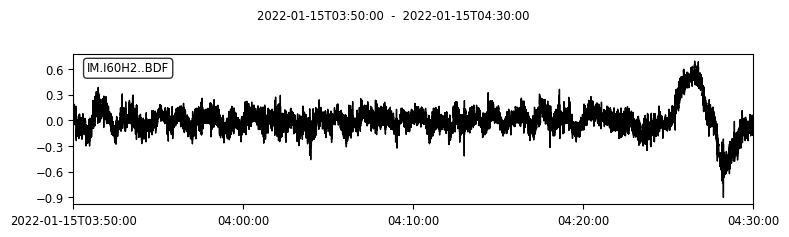

IM.I60H2..BDF 4845025.04512


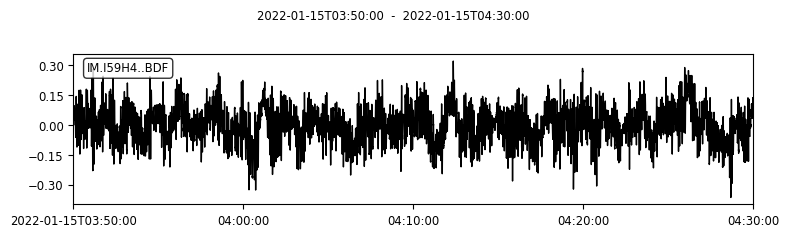

IM.I59H4..BDF 4939902.95908


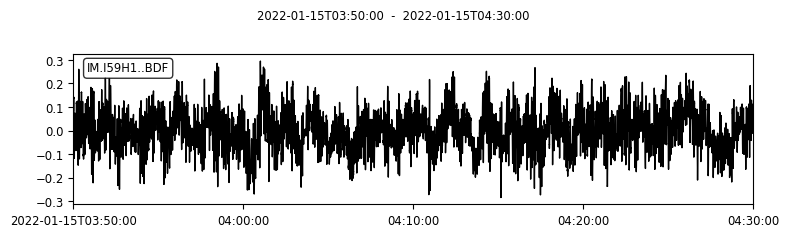

IM.I59H1..BDF 4940742.70706


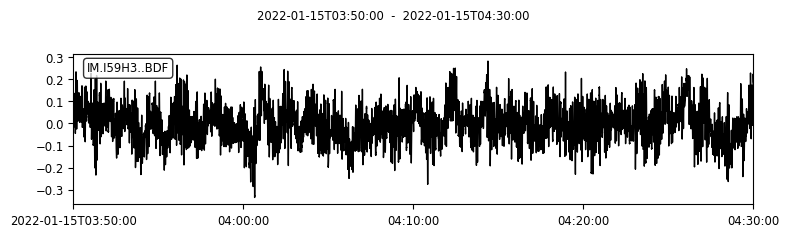

IM.I59H3..BDF 4941249.85716


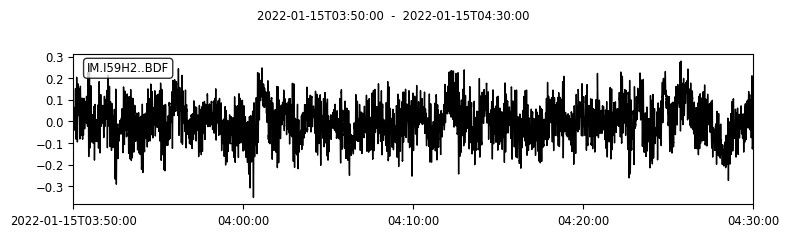

IM.I59H2..BDF 4941602.94119


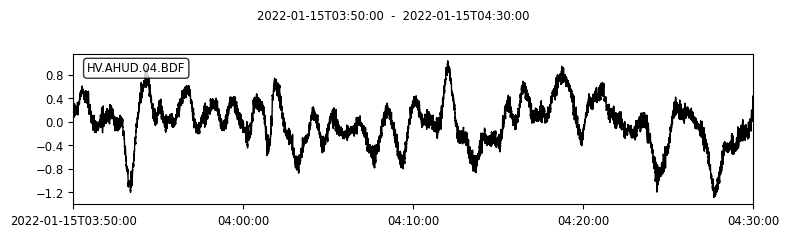

HV.AHUD.04.BDF 4948796.14231


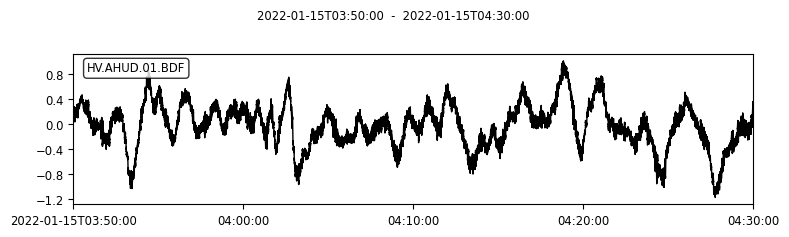

HV.AHUD.01.BDF 4948849.40119


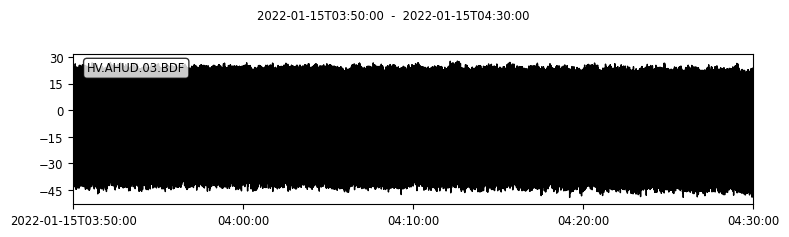

HV.AHUD.03.BDF 4948863.07383


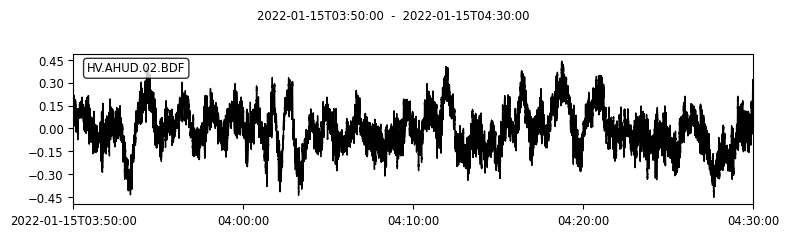

HV.AHUD.02.BDF 4948887.30091


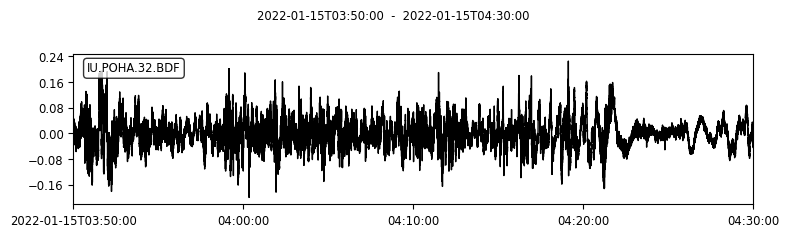

IU.POHA.32.BDF 4974184.77208


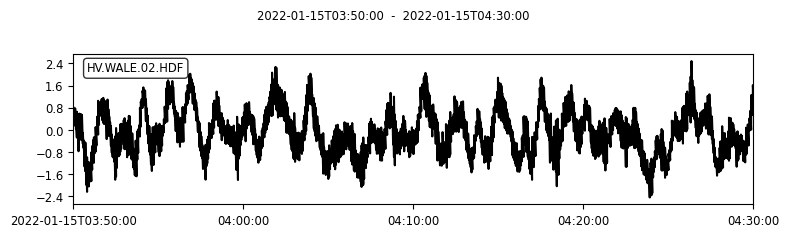

HV.WALE.02.HDF 4977870.99128


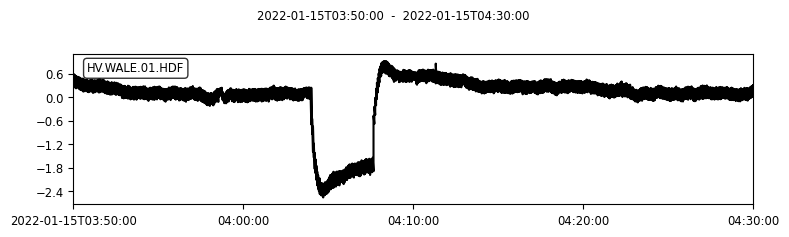

HV.WALE.01.HDF 4977884.34556


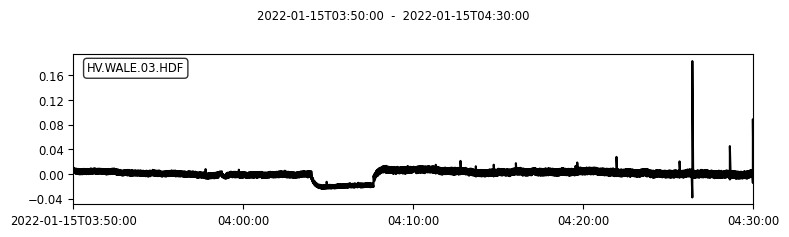

HV.WALE.03.HDF 4977887.53732


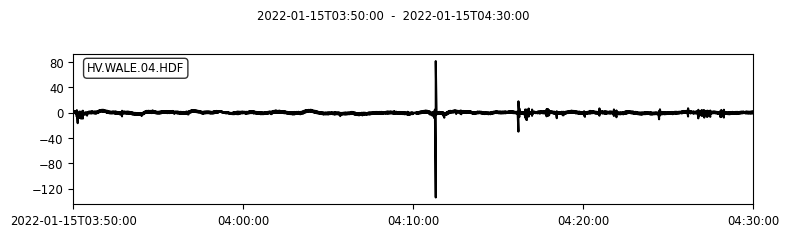

HV.WALE.04.HDF 4977927.3076


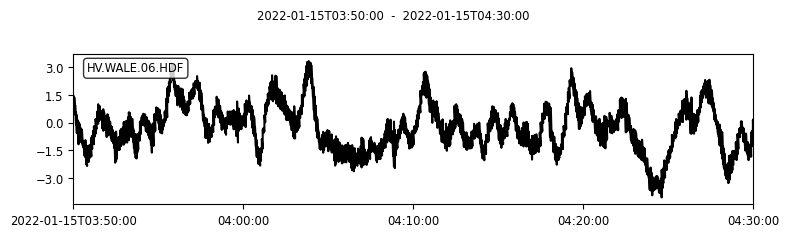

HV.WALE.06.HDF 4977933.87889


In [66]:
v = 340
stime = obspy.UTCDateTime(2022,1,15,3,50,0)
etime = obspy.UTCDateTime(2022,1,15,4,30,0)
st_infra_c = st_infra_o.copy()
for tr in st_infra_c[0:25]:
    tr.stats.starttime -= tr.stats.distance/v
    #tr.filter('highpass', freq=0.001, corners=2)
    #tr.plot(equal_scale=False, starttime=stime, endtime=etime );
    tr.filter('highpass', freq=0.01, corners=2)
    tr.plot(equal_scale=False, starttime=stime, endtime=etime );
    print(tr.id, tr.stats.distance)

## 4.2 Higher frequency seismic data

In [10]:
fmin_seismic = 0.001
searchRadiusDeg_50Hz_seismic = 45
c_seismic = 3500 # surface waves
startt_seismic_high =  startt_infrasound_high
endt_seismic_high = endt_infrasound_high
st_seismic_medium, inv_seismic_high = load_data_by_chanstring('BH?', searchRadiusDeg_50Hz_seismic, fmin_seismic, startt_seismic_high, \
                    endt_seismic_high, fdsnURL, select_good_channels=False)
st_seismic_high, inv_seismic_high = load_data_by_chanstring('HH?', searchRadiusDeg_50Hz_seismic, fmin_seismic, startt_seismic_high, \
                    endt_seismic_high, fdsnURL, select_good_channels=False)

Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_BH?_within_45_degrees_0.001000.pkl
(which we think is already reconstituted)
Enhancing
Loading /Users/thompsong/DATA/HungaTonga/PICKLE/iris_HH?_within_45_degrees_0.001000.pkl
(which we think is already reconstituted)
Enhancing


# 5. MSVF data only

In [11]:
fdsnClient = Client(fdsnURL) 
start_low = obspy.UTCDateTime(2021,12,19,0,0,0)
start_high = obspy.UTCDateTime(2022,1,12,0,0,0)
end_low = obspy.UTCDateTime(2022,1,20,0,0,0)
end_high = obspy.UTCDateTime(2022,1,17,0,0,0)
fmin = 0.0001

msvflowpklfile = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'MSVF_low_dec19_jan19_v4.pkl')
if os.path.exists(msvflowpklfile):
    msvf_low = obspy.read(msvflowpklfile)
else: 
    msvf_ld = libTonga.smart_merge(fdsnClient.get_waveforms('II', 'MSVF', '00', 'LD?', start_low, end_low))
    msvf_lh = libTonga.smart_merge(fdsnClient.get_waveforms('II', 'MSVF', '00', 'LH?', start_low, end_low))
    msvf_low = msvf_ld
    for tr in msvf_lh:
        msvf_low.append(tr)
    
    
    inv_msvf_low = fdsnClient.get_stations(
        network = msvf_low[0].stats.network,
        station = msvf_low[0].stats.station,
        channel = 'L*',
        starttime = start_low,
        endtime = end_low,
        level = 'response'
    )
    
    for tr in msvf_low:
        pre_filt_infra = [fmin, fmin*2, tr.stats.sampling_rate/4, tr.stats.sampling_rate/2.5]
        pre_filt_seismic = [fmin*10, fmin*20, tr.stats.sampling_rate/4, tr.stats.sampling_rate/2.5]
        if tr.stats.channel[1]=='H':
            tr.remove_response(inventory=inv_msvf_low, pre_filt=pre_filt_seismic, plot=False, water_level=60, output='VEL')
        else:
            tr.remove_response(inventory=inv_msvf_low, pre_filt=pre_filt_infra, plot=False, water_level=60)  
            
    msvf_low.write(msvflowpklfile, 'PICKLE')
    
    
    
msvfhighpklfile = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'MSVF_high_jan13_jan20_v2.pkl')
if os.path.exists(msvfhighpklfile):
    msvf_high = obspy.read(msvfhighpklfile)
else: 
    #msvf_bdo = libTonga.smart_merge(fdsnClient.get_waveforms('II', 'MSVF', '00', 'BDO', start_high, end_high))
    #msvf_bh = libTonga.smart_merge(fdsnClient.get_waveforms('II', 'MSVF', '00', 'BH?', start_high, end_high))
    #msvf_high = msvf_bdo
    #for tr in msvf_bh:
    #    msvf_high.append(tr)
    msvf_high = libTonga.smart_merge(fdsnClient.get_waveforms('II', 'MSVF', '00', 'BH?', start_high, end_high))
    inv_msvf_high = fdsnClient.get_stations(
        network = msvf_high[0].stats.network,
        station = msvf_high[0].stats.station,
        channel = 'B*',
        starttime = start_high,
        endtime = end_high,
        level = 'response'
    )
    
    for tr in msvf_high:
        pre_filt_infra = [fmin, fmin*2, tr.stats.sampling_rate/4, tr.stats.sampling_rate/2.5]
        pre_filt_seismic = [fmin*10, fmin*20, tr.stats.sampling_rate/4, tr.stats.sampling_rate/2.5]
        if tr.stats.channel[1]=='H':
            tr.remove_response(inventory=inv_msvf_high, pre_filt=pre_filt_seismic, plot=False, water_level=60, output='VEL')
        else:
            tr.remove_response(inventory=inv_msvf_high, pre_filt=pre_filt_infra, plot=False, water_level=60)  
                
    msvf_high.write(msvfhighpklfile, 'PICKLE')
 


# 6. Lightning data

In [12]:
# read raw lightning data
wwlln_pickle_raw = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'DF_WWLLN_RAW.pkl')
if os.path.isfile(wwlln_pickle_raw):
    wwllndf = pd.read_pickle(wwlln_pickle_raw)
else:
    wwllndf = libTonga.read_wwlln()  
    wwllndf.to_pickle(wwlln_pickle_raw)

    
gld360_pickle_raw = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'DF_GLD360_RAW.pkl')
if os.path.isfile(gld360_pickle_raw):
    gld360df = pd.read_pickle(gld360_pickle_raw)
else:
    gld360df = libTonga.read_gld360()  
    gld360df.to_pickle(gld360_pickle_raw)

                     latitude  longitude  residual  num_stations  ones  \
datetime                                                                 
2022-01-15 04:13:40  -20.4972  -175.3838      15.0            11   1.0   
2022-01-15 04:13:50    0.0000     0.0000       0.0             0   0.0   
2022-01-15 04:14:00    0.0000     0.0000       0.0             0   0.0   
2022-01-15 04:14:10  -61.6786  -525.9830      43.5            26   3.0   
2022-01-15 04:14:20  -20.5591  -175.2450      15.5             6   1.0   
...                       ...        ...       ...           ...   ...   
2022-01-15 06:45:30    0.0000     0.0000       0.0             0   0.0   
2022-01-15 06:45:40    0.0000     0.0000       0.0             0   0.0   
2022-01-15 06:45:50    0.0000     0.0000       0.0             0   0.0   
2022-01-15 06:46:00    0.0000     0.0000       0.0             0   0.0   
2022-01-15 06:46:10  -20.4765  -175.3052       1.5             5   1.0   

                     cum_events  cum_

KeyError: <class 'numpy.int64'>

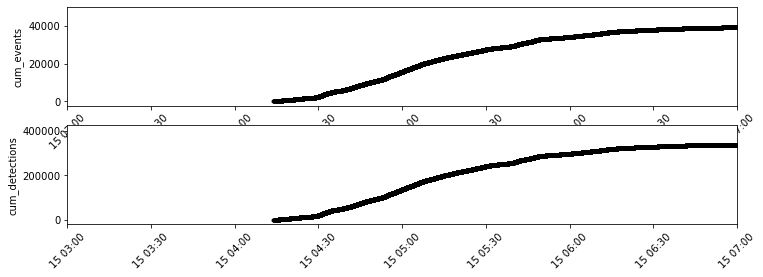

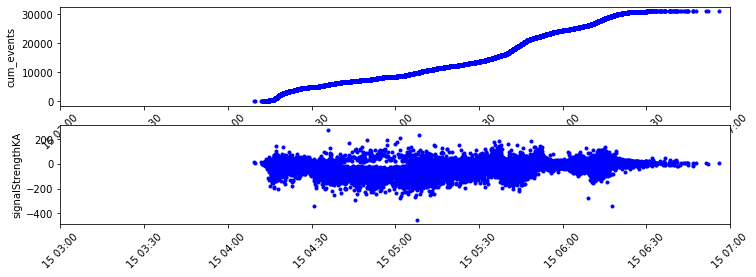

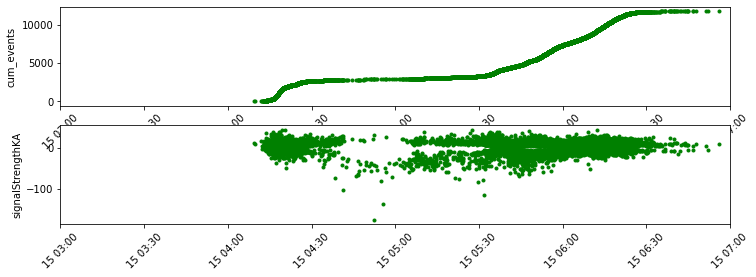

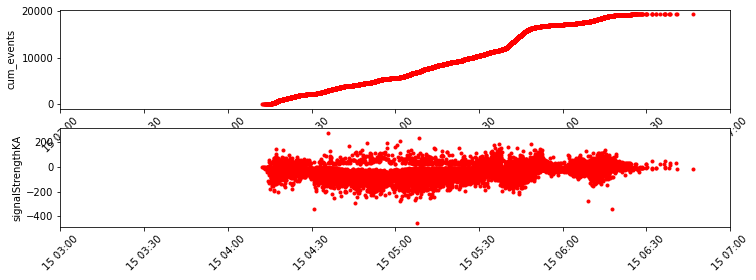

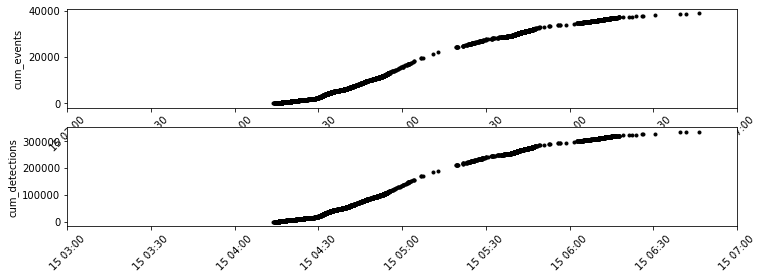

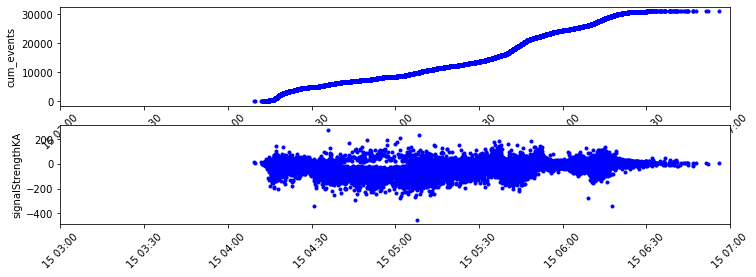

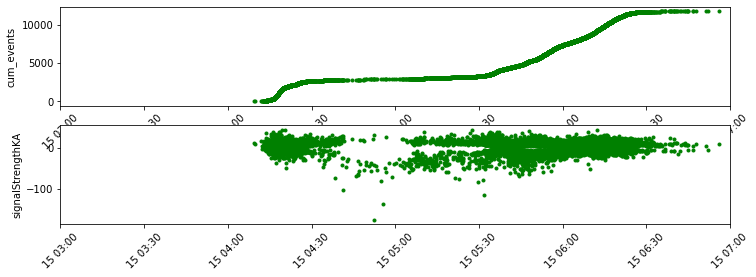

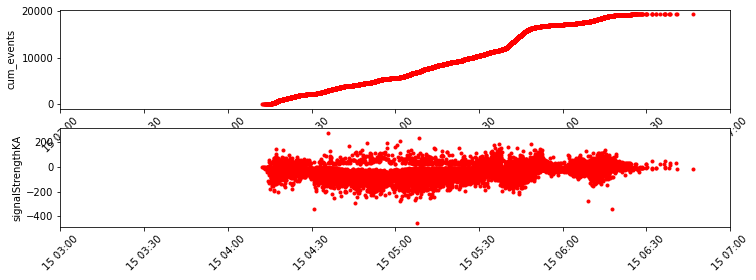

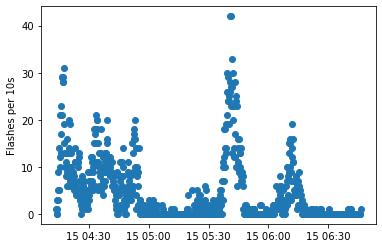

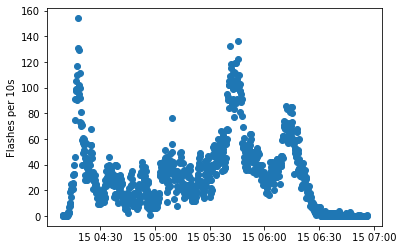

In [13]:
# plot
stime = datetime.datetime(2022, 1, 15, 3, 0, 0)
etime = datetime.datetime(2022, 1, 15, 7, 0, 0)
maxDistance = 15000.0 # was 10000
libTonga.plot_wwlln(wwllndf, starttime=stime, endtime=etime, radiusM=maxDistance )
libTonga.plot_gld360(gld360df, starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_gld360(gld360df, lightning_type='cloud2cloud', starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_gld360(gld360df, lightning_type='cloud2ground', starttime=stime, endtime=etime, radiusM=maxDistance)

# filter
wwlln_filt = libTonga.filter_df(wwllndf, starttime=stime, endtime=etime, radiusM=maxDistance)
gld360_filt = libTonga.filter_df(gld360df, starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_wwlln(wwlln_filt, starttime=stime, endtime=etime, radiusM=maxDistance )
libTonga.plot_gld360(gld360_filt, starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_gld360(gld360_filt, lightning_type='cloud2cloud', starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_gld360(gld360_filt, lightning_type='cloud2ground', starttime=stime, endtime=etime, radiusM=maxDistance)

# bin
seconds = 10
binned_wwlln = libTonga.bin_by_seconds(wwlln_filt, seconds)
binned_gld360 = libTonga.bin_by_seconds(gld360_filt, seconds)
print(binned_wwlln)
wwlln_pickle_binned = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'DF_WWLLN_binned.pkl')
if os.path.isfile(wwlln_pickle_binned):
    binned_wwlln = pd.read_pickle(wwlln_pickle_binned)
else:
    binned_wwlln = libTonga.bin_by_seconds(wwlln_filt, seconds) 
    binned_wwlln.to_pickle(wwlln_pickle_binned)
    
gld360_pickle_binned = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'DF_GLD360_binned.pkl')
if os.path.isfile(gld360_pickle_binned):
    binned_gld360 = pd.read_pickle(gld360_pickle_binned)
else:
    binned_gld360 = libTonga.bin_by_seconds(gld360_filt, seconds) 
    binned_gld360.to_pickle(gld360_pickle_binned)

# plot binned data
fig, ax = plt.subplots(1,1)
ax.plot_date(binned_wwlln.index, binned_wwlln.ones)
ax.set_ylabel('Flashes per %ds' % seconds)
fig, ax = plt.subplots(1,1)
ax.plot_date(binned_gld360.index, binned_gld360.ones)
ax.set_ylabel('Flashes per %ds' % seconds)

# create Stream
st = obspy.Stream()
st.append(libTonga.column2Trace(binned_wwlln, 'ones', seconds, net='UW', sta='WWLLN', chan='CNT'))
st.append(libTonga.column2Trace(binned_wwlln, 'num_stations', seconds, net='UW', sta='WWLLN', chan='DET'))
st.append(libTonga.column2Trace(binned_wwlln, 'weightedDetections', seconds, net='UW', sta='WWLLN', chan='WDE'))
st.append(libTonga.column2Trace(binned_gld360, 'ones', seconds, net='VA', sta='GLD36', chan='CNT'))
st.append(libTonga.column2Trace(binned_gld360, 'signalPower', seconds, net='VA', sta='GLD36', chan='PWR'))
st.append(libTonga.column2Trace(binned_gld360, 'weightedPower', seconds, net='VA', sta='GLD36', chan='WPW'))
lightningmseed = os.path.join(libTonga.DATA_ROOT, 'MINISEED', 'lightning.mseed')
st.write(lightningmseed)

<Figure size 864x864 with 0 Axes>

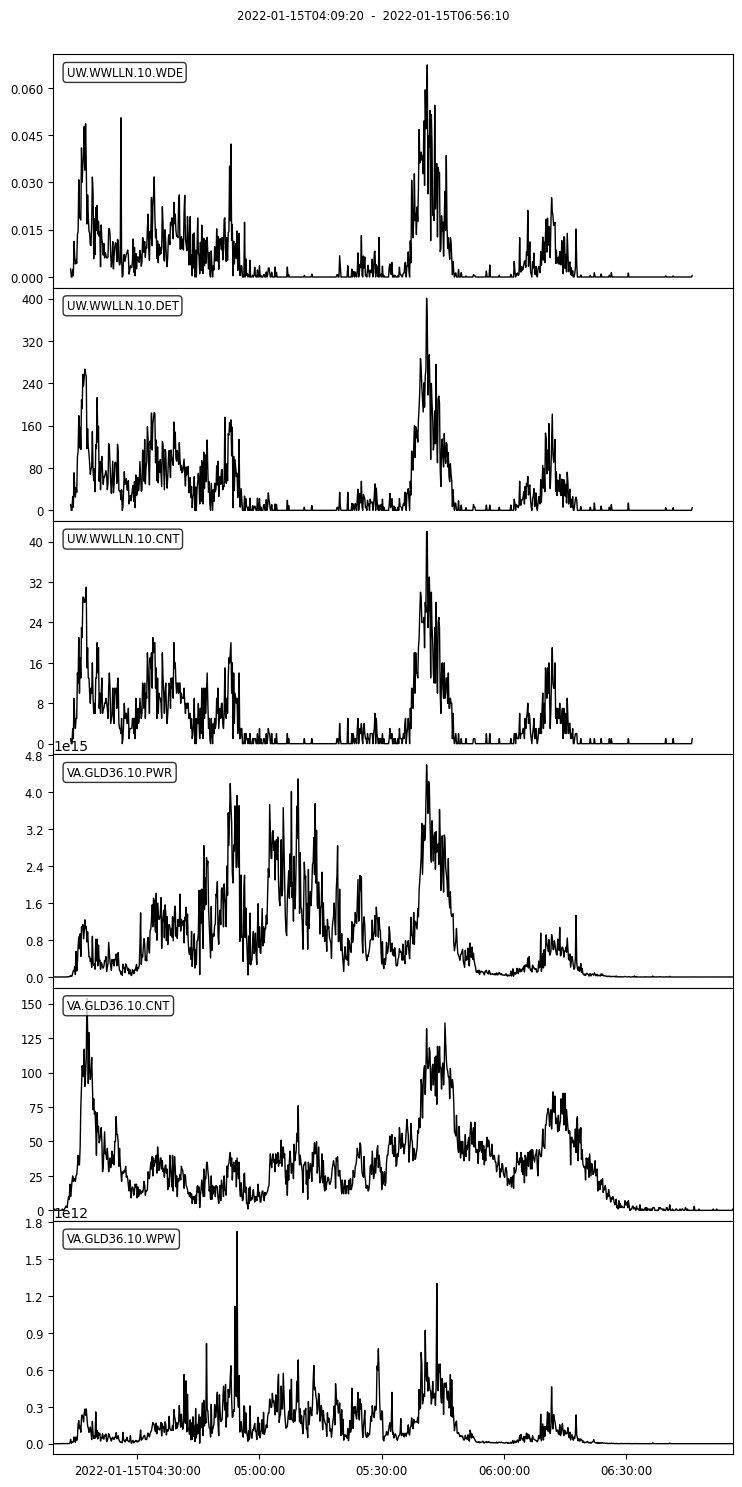

In [14]:
# plot Stream
fig  = plt.figure(figsize=(12,12))
#st.plot(equal_scale=False, starttime=obspy.UTCDateTime(stime), endtime=obspy.UTCDateTime(etime), fig=fig);  
st.plot(equal_scale=False);
ax = fig.axes
for this_ax in ax:
    this_ax.grid()

# 6. Poster figures
- compute moveout speed of N wave peak times
- Supersonic travel speed vs distance
- Pressure versus distance, corrected for actual circumference of wavefronts on a spherical earth
- Lightning vs seismic vs infrasound: Filter lightning, seismic, infrasound above 0.1 Hz from January 13-15.
- Potentially look at different lightning types - do some correspond to infrasound -ve phase?
- Ground coupled airwave amplitude vs airwave at different frequencies
- Time from seismic to infrasound to lightning origin, if I can figure that out
- Examine particle motion of those initial seismic waves
- - get GISMO and Antelope licence)
- Look for Youtube/human reported blasts in high frequency infrasound? 
- Examine amplitude, duration, and area to peak and under positive and negative portions of the Lamb wave. 

Model as a cylindrical source of tropospheric height? What about radius? A rise time of say 15 minutes might indicate a radius of say 900 s * 314 m/s = 280 km.

## 6.1 Overview plot of ash column height, lightning event rate, seismic, and barometric data from MSVF
This should extend from at least Jan 13-16.


                     longitude  latitude  signalStrengthKA  cloud  distanceM  \
datetime                                                                       
2021-12-19 20:41:10  -175.3759  -20.5527               3.7      1       1963   
2021-12-19 20:41:20  -350.7481  -41.0794               0.1      1       3091   
2021-12-19 20:41:30 -1227.8247 -143.4534              38.3      6      41413   
2021-12-19 20:41:40 -1227.8153 -143.6052             -10.1      5      36316   
2021-12-19 20:41:50 -1403.2901 -164.0043             -15.1      5      48321   
...                        ...       ...               ...    ...        ...   
2022-01-15 22:27:00     0.0000    0.0000               0.0      0          0   
2022-01-15 22:27:10     0.0000    0.0000               0.0      0          0   
2022-01-15 22:27:20     0.0000    0.0000               0.0      0          0   
2022-01-15 22:27:30     0.0000    0.0000               0.0      0          0   
2022-01-15 22:27:40  -175.2669  -20.5942

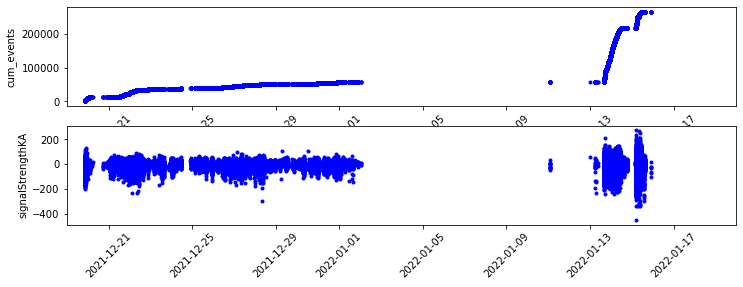

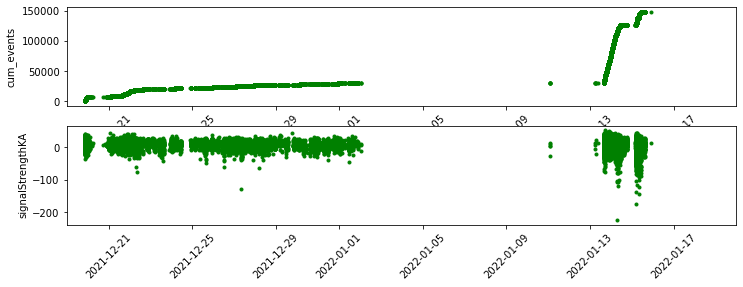

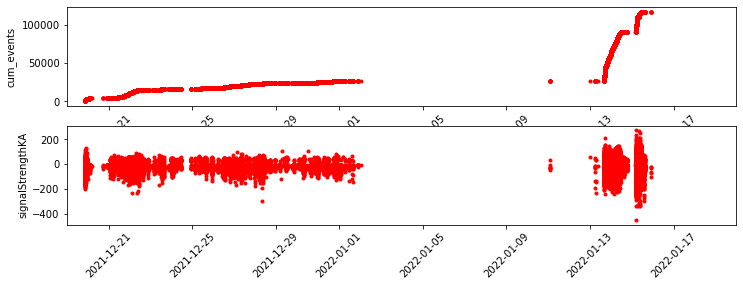

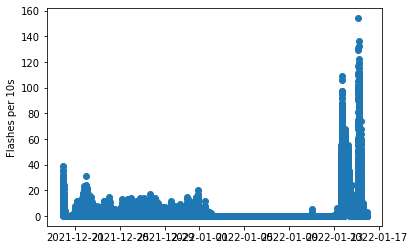

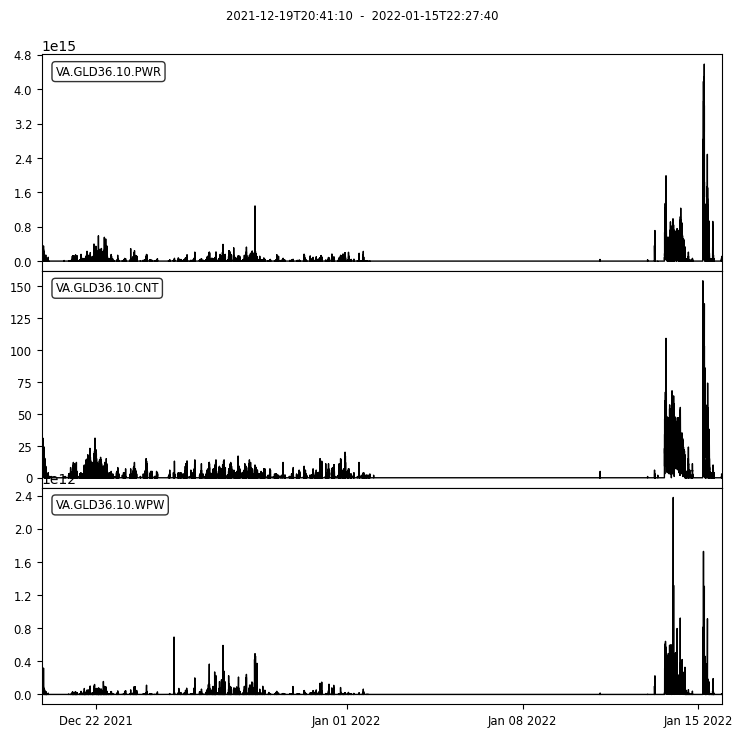

In [15]:
# filter
maxDistance = 15000
stime = datetime.datetime(2021, 12, 19, 0, 0, 0)
etime = datetime.datetime(2022, 1, 20, 0, 0, 0)
gld360_filt = libTonga.filter_df(gld360df, starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_gld360(gld360_filt, starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_gld360(gld360_filt, lightning_type='cloud2cloud', starttime=stime, endtime=etime, radiusM=maxDistance)
libTonga.plot_gld360(gld360_filt, lightning_type='cloud2ground', starttime=stime, endtime=etime, radiusM=maxDistance)

# bin
seconds = 10
binned_gld360 = libTonga.bin_by_seconds(gld360_filt, seconds)
gld360_pickle_binned = os.path.join(libTonga.DATA_ROOT, 'PICKLE', 'DF_GLD360_binned_3days.pkl')
overwrite=True
if os.path.isfile(gld360_pickle_binned) and overwrite==False:
    binned_gld360 = pd.read_pickle(gld360_pickle_binned)
else:
    binned_gld360 = libTonga.bin_by_seconds(gld360_filt, seconds) 
    binned_gld360.to_pickle(gld360_pickle_binned)

# plot binned data
fig, ax = plt.subplots(1,1)
ax.plot_date(binned_gld360.index, binned_gld360.ones)
ax.set_ylabel('Flashes per %ds' % seconds)

# create Stream
lightningst = obspy.Stream()
lightningst.append(libTonga.column2Trace(binned_gld360, 'ones', seconds, net='VA', sta='GLD36', chan='CNT'))
lightningst.append(libTonga.column2Trace(binned_gld360, 'signalPower', seconds, net='VA', sta='GLD36', chan='PWR'))
lightningst.append(libTonga.column2Trace(binned_gld360, 'weightedPower', seconds, net='VA', sta='GLD36', chan='WPW'))
lightningmseed = os.path.join(libTonga.DATA_ROOT, 'MINISEED', 'lightning3days.mseed')
lightningst.write(lightningmseed)

lightningst.plot(equal_scale=False);

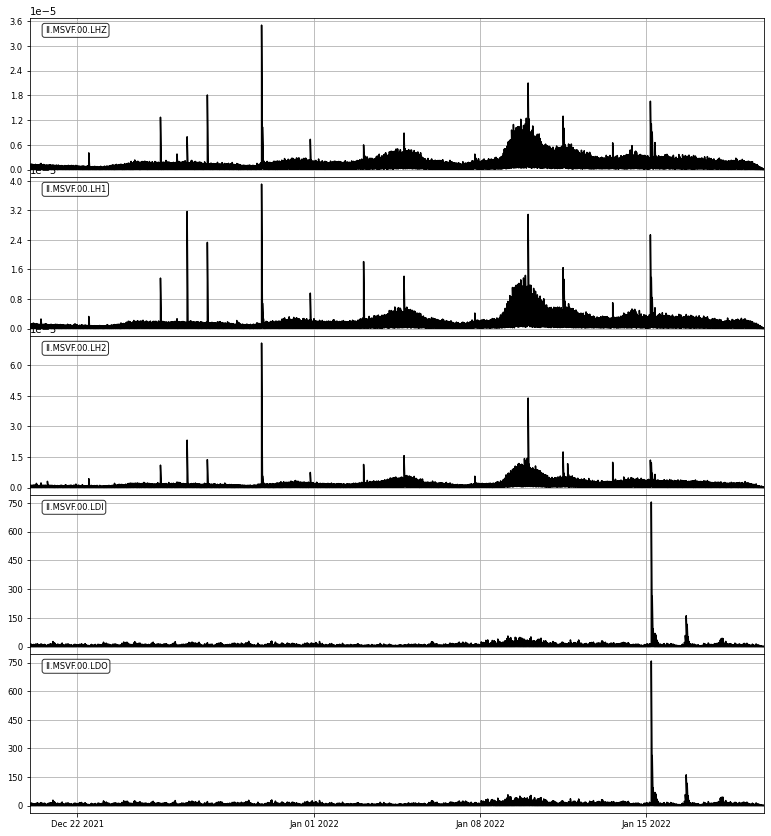

In [17]:
msvf_low2 = msvf_low.copy().trim(starttime=obspy.UTCDateTime(2021,12,20), endtime=obspy.UTCDateTime(2022,1,20))
msvf_low_filtered = msvf_low2.filter('highpass', freq=0.0001, corners=2)
#msvf_low_filtered.plot(equal_scale=False);
msvf_rsam = msvf_low_filtered.copy()
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
for tr in msvf_rsam:
    y = tr.data
    y2 = moving_average(np.abs(y),10)
    tr.data = y2
fig = plt.figure(figsize=(12,12))
msvf_rsam.plot(equal_scale=False, fig=fig);
ax = fig.axes
for this_ax in ax:
    this_ax.grid()
plt.show()  

(array([ 19007.125     ,  19007.16666667,  19007.20833333,  19007.25      ,
         19007.29166667]),
 [Text(19007.125, 0, '2022-01-15T03:00'),
  Text(19007.1666667, 0, '04:00'),
  Text(19007.2083333, 0, '05:00'),
  Text(19007.25, 0, '06:00'),
  Text(19007.2916667, 0, '07:00')])

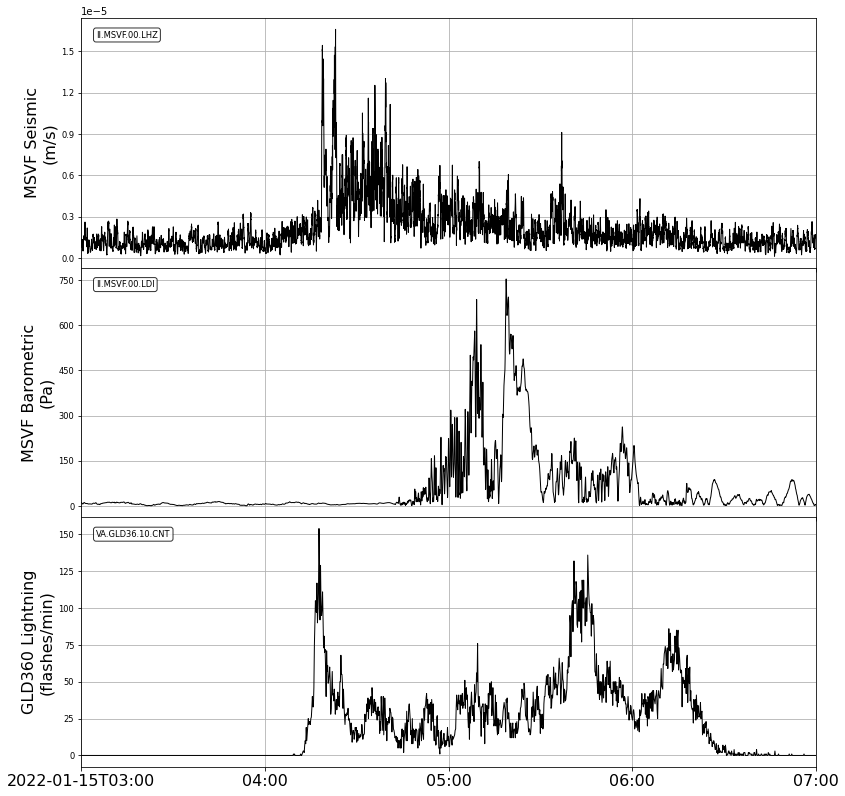

In [20]:
fig = plt.figure(figsize=(12,12))
new_st = msvf_rsam.select(channel='LHZ')
new_st.append(msvf_rsam.select(channel='LDI')[0])
new_st.append(lightningst.select(channel='CNT')[0])
new_st.trim(starttime=obspy.UTCDateTime(2022,1,15,3,0,0), endtime=obspy.UTCDateTime(2022,1,15, 7, 0, 0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n(m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/min)']
for c,this_ax in enumerate(ax):
    this_ax.grid()
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 
#plt.savefig('lightning_infrasound_correlation.eps')

In [ ]:
fig = plt.figure(figsize=(12,12))
new_st = msvf_rsam.select(channel='LHZ')
new_st.append(msvf_rsam.select(channel='LDI')[0])
new_st.append(lightningst.select(channel='CNT')[0])
new_st.append(lightningst.select(channel='WPW')[0])
new_st.trim(starttime=obspy.UTCDateTime(2022,1,13,6,0,0), endtime=obspy.UTCDateTime(2022,1,16))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n(m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/min)', 'GLD360 Weighted Current\n(W/min-km)']
for c,this_ax in enumerate(ax):
    this_ax.grid()
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 
plt.savefig('lightning_infrasound_correlation_more.eps')

In [ ]:
fig = plt.figure(figsize=(12,12))
new_st = msvf_rsam.copy().select(channel='LH?')
#new_st.append(msvf_rsam.select(channel='LDO')[0])
new_st.append(msvf_rsam.select(channel='LDI')[0])
new_st.append(lightningst.select(channel='CNT')[0])
new_st.append(lightningst.select(channel='WPW')[0])
new_st.trim(starttime=obspy.UTCDateTime(2022,1,13,15,20,0), endtime=obspy.UTCDateTime(2022,1,13,17,30,0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n(m/s)',  'MSVF Seismic\n(m/s)', 'MSVF Seismic\n(m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/min)', 'GLD360 Weighted Current\n(W/min-km)']
for c,this_ax in enumerate(ax):
    this_ax.grid()
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 
plt.savefig('lightning_infrasound_correlation_jan13.eps')

In [ ]:
fig = plt.figure(figsize=(12,12))
new_st = msvf_rsam.copy().select(channel='LH2')
#new_st.append(msvf_rsam.select(channel='LDO')[0])
new_st.append(msvf_rsam.copy().select(channel='LDI')[0])
new_st.append(lightningst.copy().select(channel='CNT')[0])
new_st.append(lightningst.copy().select(channel='WPW')[0])
new_st.trim(starttime=obspy.UTCDateTime(2022,1,15,3,45,0), endtime=obspy.UTCDateTime(2022,1,15,6,30,0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n(m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/min)', 'GLD360 Weighted Current\n(W/min-km)']
for c,this_ax in enumerate(ax):
    this_ax.grid()
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 
plt.savefig('lightning_infrasound_correlation_jan15_3h.eps')

In [ ]:
fig = plt.figure(figsize=(12,12))
new_st = msvf_rsam.copy().select(channel='LH2')
new_st[0].stats.starttime -= 100
#new_st.append(msvf_rsam.select(channel='LDO')[0])
new_st.append(msvf_rsam.copy().select(channel='LDI')[0])
new_st[1].stats.starttime -= 757000/314
new_st.append(lightningst.copy().select(channel='CNT')[0])
new_st.append(lightningst.copy().select(channel='WPW')[0])
new_st.trim(starttime=obspy.UTCDateTime(2022,1,15,3,45,0), endtime=obspy.UTCDateTime(2022,1,15,6,30,0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n(m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/min)', 'GLD360 Weighted Current\n(W/min-km)']
for c,this_ax in enumerate(ax):
    this_ax.grid()
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 
plt.savefig('lightning_infrasound_correlation_jan15_3h.eps')

In [ ]:
fig = plt.figure(figsize=(12,12))
new_st = msvf_low.copy().select(channel='LHZ').filter('lowpass', freq=0.1, corners=2)
new_st[0].stats.starttime -= 100
#new_st.append(msvf_rsam.select(channel='LDO')[0])
new_st.append(msvf_low.copy().select(channel='LDI')[0])
new_st[1].stats.starttime -= 757000/314
new_st.append(lightningst.copy().select(channel='CNT')[0])
new_st.append(lightningst.copy().select(channel='WPW')[0])
new_st.trim(starttime=obspy.UTCDateTime(2022,1,15,3,45,0), endtime=obspy.UTCDateTime(2022,1,15,6,30,0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n(m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/min)', 'GLD360 Weighted Current\n(W/min-km)']
for c,this_ax in enumerate(ax):
    this_ax.grid()
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 
plt.savefig('lightning_infrasound_correlation_jan15_3h.eps')

In [ ]:
fig = plt.figure(figsize=(12,12))
new_st = msvf_low.copy().select(channel='LDI').filter('lowpass', freq=0.01, corners=2)
#new_st[0].stats.starttime -= 100
#new_st.append(msvf_rsam.select(channel='LDO')[0])
new_st.append(msvf_low.copy().select(channel='LDI')[0])
#new_st[1].stats.starttime -= 757000/314
new_st.append(lightningst.copy().select(channel='CNT')[0])
new_st.append(lightningst.copy().select(channel='WPW')[0])
new_st.trim(starttime=obspy.UTCDateTime(2022,1,15,3,45,0), endtime=obspy.UTCDateTime(2022,1,15,6,30,0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n(m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/min)', 'GLD360 Weighted Current\n(W/min-km)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)    

#plt.show() 
plt.savefig('lightning_infrasound_correlation_jan15_3h_Nwave.eps')

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
dist = 757000
c_pwave = 7500
c_surface = 3900
c_lamb = 300
fig = plt.figure(figsize=(12,12))
new_st = msvf_low.copy().select(channel='LHZ').filter('lowpass', freq=0.3/seconds, corners=2)
new_st[0].stats.starttime -= dist/c_surface
new_st[0].data *= 1e6
new_st.append(msvf_low.copy().select(channel='LDI')[0])
new_st[-1].stats.starttime -= dist/c_lamb
lst2 = lightningst.copy()
for tr in lst2:
    tr.data = tr.data/seconds
lst2[-1].data *= 1e-9
new_st.append(lst2.select(channel='CNT')[0])
new_st.append(lst2.select(channel='WPW')[0])

new_st.trim(starttime=obspy.UTCDateTime(2022,1,12,23,59,0), endtime=obspy.UTCDateTime(2022,1,16,0,1,0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n($\mu$m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/s)', 'GLD360 Weighted Current\n(GW/m)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 


plt.savefig('lightning_infrasound_correlation_jan13_15_reduced.pdf')

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig = plt.figure(figsize=(12,12))
new_st = msvf_low.copy().select(channel='LHZ').filter('lowpass', freq=0.3/seconds, corners=2)
#new_st[0].stats.starttime -= dist/c_surface
new_st[0].data *= 1e6
new_st.append(msvf_low.copy().select(channel='LDI')[0])
#new_st[-1].stats.starttime -= dist/c_lamb
lst2 = lightningst.copy()
for tr in lst2:
    tr.data = tr.data/seconds
lst2[-1].data *= 1e-9
new_st.append(lst2.select(channel='CNT')[0])
#new_st.append(lst2.select(channel='WPW')[0])

new_st.trim(starttime=obspy.UTCDateTime(2022,1,12,23,59,0), endtime=obspy.UTCDateTime(2022,1,16,0,1,0))
new_st.plot(equal_scale=False, fig=fig);
ax = fig.axes
ylabels=['MSVF Seismic\n($\mu$m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/s)', 'GLD360 Weighted Current\n(GW/m)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 


plt.savefig('lightning_infrasound_correlation_jan13_15.pdf')

In [ ]:
fig3 = plt.figure(figsize=(12,12))
new_st2 = new_st.copy()
#new_st2[0:2].filter('highpass', freq=0.01, corners=2)
stime = obspy.UTCDateTime(2022, 1, 15, 7, 20, 0)
etime = obspy.UTCDateTime(2022, 1, 15, 9, 50, 0)
new_st2.trim(starttime=stime, endtime=etime)
new_st2.plot(equal_scale=False, fig=fig3);
ax = fig3.axes
ylabels=['MSVF Seismic\n($\mu$m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/s)', 'GLD360 Weighted Current\n(GW/m)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 


plt.savefig('lightning_infrasound_correlation_jan15_2ndevent.pdf')

In [ ]:
fig3 = plt.figure(figsize=(12,12))
new_st2 = new_st.copy()
#new_st2[0:2].filter('highpass', freq=0.01, corners=2)
stime = obspy.UTCDateTime(2022, 1, 15, 0, 0, 0)
etime = obspy.UTCDateTime(2022, 1, 16, 0, 0, 0)
new_st2.trim(starttime=stime, endtime=etime)
new_st2.plot(equal_scale=False, fig=fig3);
ax = fig3.axes
ylabels=['MSVF Seismic\n($\mu$m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/s)', 'GLD360 Weighted Current\n(GW/m)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 


plt.savefig('lightning_infrasound_correlation_jan15.pdf')

In [ ]:
fig3 = plt.figure(figsize=(12,12))
new_st2 = new_st.copy()
#new_st2[0:2].filter('highpass', freq=0.01, corners=2)
stime = obspy.UTCDateTime(2022, 1, 15, 3, 45, 0)
etime = obspy.UTCDateTime(2022, 1, 15, 6, 45, 0)
new_st2.trim(starttime=stime, endtime=etime)
new_st2.plot(equal_scale=False, fig=fig3);
ax = fig3.axes
ylabels=['MSVF Seismic\n($\mu$m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/s)', 'GLD360 Weighted Current\n(GW/m)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 


plt.savefig('lightning_infrasound_correlation_jan15_3h.pdf')

In [ ]:
fig3 = plt.figure(figsize=(12,12))
new_st2 = new_st.copy()
new_st2[0:2].filter('lowpass', freq=0.01, corners=2)
stime = obspy.UTCDateTime(2022, 1, 15, 3, 45, 0)
etime = obspy.UTCDateTime(2022, 1, 15, 6, 45, 0)
new_st2.trim(starttime=stime, endtime=etime)
new_st2.plot(equal_scale=False, fig=fig3);
ax = fig3.axes
ylabels=['MSVF Seismic\n($\mu$m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/s)', 'GLD360 Weighted Current\n(GW/m)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
#plt.show() 


# THISplt.savefig('lightning_infrasound_correlation_jan15_3h_isolateNwave.pdf')

In [ ]:
# THIS IS THE KEY FIGURE
c_pwave = 7500
c_surface = 3900
c_infrasound = 299
c_lamb = 314

reduced_st = obspy.Stream()
reduced_st.append(new_st[0].copy())
reduced_st[0].stats.starttime -= dist/c_surface
reduced_st[0].id = '05.Seis..LHZ'
reduced_st[0].data *= 29.5/1000 # 23 kPa/780 Pa

reduced_st.append(new_st[0].copy())
reduced_st[1].stats.starttime -= dist/c_infrasound
reduced_st[1].id = '04.GCpld..LHZ'
reduced_st[1].data *= 218/1000 # 170 kPa/780 Pa to kPa

reduced_st.append(new_st[1].copy())
reduced_st[2].stats.starttime -= dist/c_infrasound
reduced_st[2].id = '03.Infra..LDI'
reduced_st[2].filter('highpass', freq=0.01, corners=2)
reduced_st[2].data *= 218/1000

reduced_st.append(new_st[1].copy())
reduced_st[3].stats.starttime -= dist/c_lamb + 26.6
reduced_st[3].id = '02.Lamb..LDI'
reduced_st[3].filter('lowpass', freq=0.02, corners=2)
reduced_st[3].data *= 218/1000

reduced_st.append(new_st[2].copy())
reduced_st[4].id = '01.GLD36..CNT'

fig3 = plt.figure(figsize=(12,12))
reduced_st2 = reduced_st.copy()
#new_st2[0:2].filter('highpass', freq=0.01, corners=2)
stime = obspy.UTCDateTime(2022, 1, 15, 3, 55, 0)
etime = obspy.UTCDateTime(2022, 1, 15, 4, 55, 0)
reduced_st2.trim(starttime=stime, endtime=etime)
reduced_st2[1].taper(18)
reduced_st2.plot(equal_scale=False, fig=fig3);
ax = fig3.axes
ylabels=['GLD360 Lightning\n(flashes/s)',  'Lamb wave\n(kPa)', 'Infrasound\n(kPa)', 'Ground-coupled\nAirwaves (mm/s)', 'Seismic waves\n(mm/s)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('lightning_infrasound_seismic_wave_separation_jan15_1h_reduced.pdf')

In [ ]:
c_pwave = 7500
c_surface = 3500
c_infrasound = 300
c_lamb = 314
reduced_st = new_st.copy()
reduced_st[0].stats.starttime -= dist/c_pwave
reduced_st[1].stats.starttime -= dist/c_lamb

fig3 = plt.figure(figsize=(12,12))
reduced_st2 = reduced_st.copy()
#new_st2[0:2].filter('highpass', freq=0.01, corners=2)
stime = obspy.UTCDateTime(2022, 1, 15, 3, 55, 0)
etime = obspy.UTCDateTime(2022, 1, 15, 4, 45, 0)
reduced_st2.trim(starttime=stime, endtime=etime)
reduced_st2.plot(equal_scale=False, fig=fig3);
ax = fig3.axes
ylabels=['MSVF Seismic\n($\mu$m/s)', 'MSVF Barometric\n(Pa)', 'GLD360 Lightning\n(flashes/s)', 'GLD360 Weighted Current\n(GW/m)']
for c,this_ax in enumerate(ax):
    this_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    this_ax.grid(which='minor', ls=':')
    this_ax.grid(which='major', ls='-')
    this_ax.set_ylabel(ylabels[c], fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('lightning_infrasound_correlation_jan15_1h_reduced2.pdf')

In [ ]:
import matplotlib as mpl
import string
mpl.rcParams["font.size"] = 16
stime = datetime.datetime(2022, 1, 15, 4, 0, 0)
etime = datetime.datetime(2022, 1, 15, 5, 30, 0)
import matplotlib.dates as mdates
def plot_gld360(df, starttime='1900-01-01', endtime='2100-01-01', lightning_type=None, radiusM=300000,
                 metric='counts'):


    df2 = df.loc[(df['datetime'] >= starttime) & (df['datetime'] < endtime)]
    fig = plt.figure(figsize =(16, 16))

    ax_i = 0
    
    for radiusM in [300000, 15000]:
        df3 = df2.loc[df2['distanceM'] < radiusM]          
        for metric in ['counts', 'distance']:
            ax = fig.add_subplot(2, 2, ax_i+1)
                     
            for lightning_type in ['C2C', 'C2G' ]:
                if lightning_type == 'C2C':
                    df4 = df3.loc[df2['cloud']==True]
                elif lightning_type == 'C2G':
                    df4 = df3.loc[df2['cloud']==False]
                for current in ['-', '+']:      
                    if current == '-':
                        df5 = df4.loc[df3['signalStrengthKA']<0]
                    else:
                        df5 = df4.loc[df3['signalStrengthKA']>0]

                    if metric=='counts':    
                        cum_events = np.cumsum(df5['ones'])
                        ax.plot_date(df5['datetime'], cum_events, fmt='-', linewidth=2, label = '%s%s' % (lightning_type, current ))
                    elif metric=='distance':
                        av_distance = moving_average(df5['distanceM'],300)
                        av_time = df5['datetime']
                        av_time = av_time[-len(av_distance):]
                        ax.plot_date(av_time, av_distance/1000, fmt='-', linewidth=2, label = '%s%s' % (lightning_type, current ))
                xfmt = mdates.DateFormatter('%H:%M')
                ax.xaxis.set_major_formatter(xfmt)
                #ax.set_xticks(dates)        
                xtl = ax.get_xticklabels()
                plt.setp(xtl, rotation=90)
                if starttime:
                    ax.set_xlim(starttime, endtime)
                plt.legend()
                if metric=='counts':
                    plt.ylabel('Cumulative flashes\nwithin %.0f km' % (radiusM/1000))
                elif metric=='distance':
                    plt.ylabel('Mean distance (km)\nwithin %.0f km' % (radiusM/1000))
            ax.text(-0.15, 0.99, string.ascii_uppercase[ax_i], transform=ax.transAxes, size=24, weight='bold')
            ax_i += 1
    
    return

gld360_filt2 = libTonga.filter_df(gld360df, starttime=stime, endtime=etime)
plot_gld360(gld360_filt2, starttime=stime, endtime=etime)
#plt.show()
plt.savefig('lightning_analysis.pdf')

In [ ]:
r_msvf = 757.0 # km
P_msvf = 780.0 # Pa
vambient = 314

r_list, P_list, v_list, t_list, M_list = libTonga.pressure_vs_distance(r_msvf, \
                            P_msvf, crossover_km=0, vambient=vambient)

plt.figure(figsize=(4,4))
plt.loglog(r_list, P_list)
plt.xlabel('Distance (km)')
plt.ylabel('Overpressure (Pa)')


plt.figure(figsize=(8, 5))
plt.semilogx(r_list, v_list)
plt.xlabel('Distance (km)')
plt.ylabel('Speed (m/s)')
plt.semilogx([1, 10000], [vambient*1.01, vambient*1.01])
plt.grid('both')
plt.tight_layout()
plt.savefig('supersonic_speed_v_distance.pdf')

plt.figure(figsize=(4,4))
plt.plot(r_list, t_list)
t2_list = np.array(r_list)*1000/vambient # sound speed travel times
plt.plot(r_list, t2_list)
plt.xlabel('Distance (km)')
plt.ylabel('Travel time (s)')

ttdiff = t2_list - t_list

plt.figure(figsize=(8, 5))
plt.plot(r_list, ttdiff)
plt.xlabel('Distance (km)')
plt.ylabel('Time difference (s)')
plt.grid('both')
plt.plot(757, 26.66, 'o')
plt.tight_layout()
plt.xlim([1, 800])
plt.ylim([0, 30])
plt.savefig('supersonic_ttdiff_v_distance.pdf')

c = 0
while r_list[c] < 757:
    c += 1
print(r_list[c], ttdiff[c])


In [ ]:
si = 42220
print(r_list[si], v_list[si], P_list[si])
print(r_list[si]*1000/t_list[si])

si = 66320
print(r_list[si], v_list[si], P_list[si])
print(r_list[si]*1000/t_list[si])

In [ ]:
# Data from Matt Haney
tonga_barometer_file = os.path.join(libTonga.DATA_ROOT, 'TongaTsunami_BaroPres.csv')
tonga_barometer_df = pd.read_csv(tonga_barometer_file)


In [ ]:
print(tonga_barometer_df)

In [ ]:
tonga_barometer_df.columns=['datetime', 'pressure', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8']

In [ ]:
tonga_barometer_df.loc[0]['datetime']

In [ ]:
obspy.UTCDateTime(tonga_barometer_df.loc[0]['datetime'])

In [ ]:
for i, row in tonga_barometer_df.iterrows():
    tonga_barometer_df.loc[i]['datetime'] = obspy.UTCDateTime(tonga_barometer_df.loc[i]['datetime'])

In [ ]:
import numpy as np
st68 = obspy.Stream()
tr = obspy.Trace()
tr.data = np.array(tonga_barometer_df['pressure'])
tr.stats.starttime = tonga_barometer_df.loc[0]['datetime']
tr.stats.delta = 60
tr.id = 'TO.TONGA..LDO'
tr.stats['latitude'] = -21.1303
tr.stats['longitude'] = -175.1967
tr.data *= 100
st68.append(tr)
st68.plot();
st68.write('barometric_pressure_at_68km.mseed')

In [ ]:
stf = st68.copy()
stf.detrend('linear')
#stf.taper(3)
stf.filter('highpass', freq=0.0001, corners=2)
stime = obspy.UTCDateTime(2022,1,15,4,0,0)
etime = stime + 3600
stf.plot(starttime=stime, endtime=etime);

In [ ]:
len(tr.data)

In [ ]:
st_compare = obspy.Stream()
st_compare.append(st68[0].copy())
for tr in msvf_low:
    st_compare.append(tr)
st_compare.detrend('linear')
#stf.taper(3)
st_compare.filter('highpass', freq=0.0001, corners=2)

In [ ]:
stime = obspy.UTCDateTime(2022,1,15,3,40,0)
etime = stime + 2700
st_compare.plot(starttime=stime, endtime=etime, equal_scale=False);

In [ ]:
# Q. what is the decay from a line source section, e.g. 0-58 km height?
# That would look like a point source in the far field.
# But what about in the near field, if it was just a source of cylindrical waves?
44*60+20

In [ ]:
(757-68)*1000/2660

In [ ]:
# 4:35:30
# 5:09:10
# 33:40
tdiff = 33*60+30
v = (757-68)/tdiff

In [ ]:
v

In [ ]:
36*60+39

In [ ]:
from obspy.geodetics import locations2degrees
locations2degrees(libTonga.sourcelat, libTonga.sourcelon, -21.1303, -175.1967)

In [ ]:
0.619*111

In [ ]:
(757-68.7)*1000/(36*60+39+0)

In [ ]:
314*3000

In [5]:
chanstring = 'BDF'
infile = '/Users/thompsong/DATA/HungaTonga/MINISEED/iris_BDF_good.mseed'
st_bdf = obspy.read(infile)

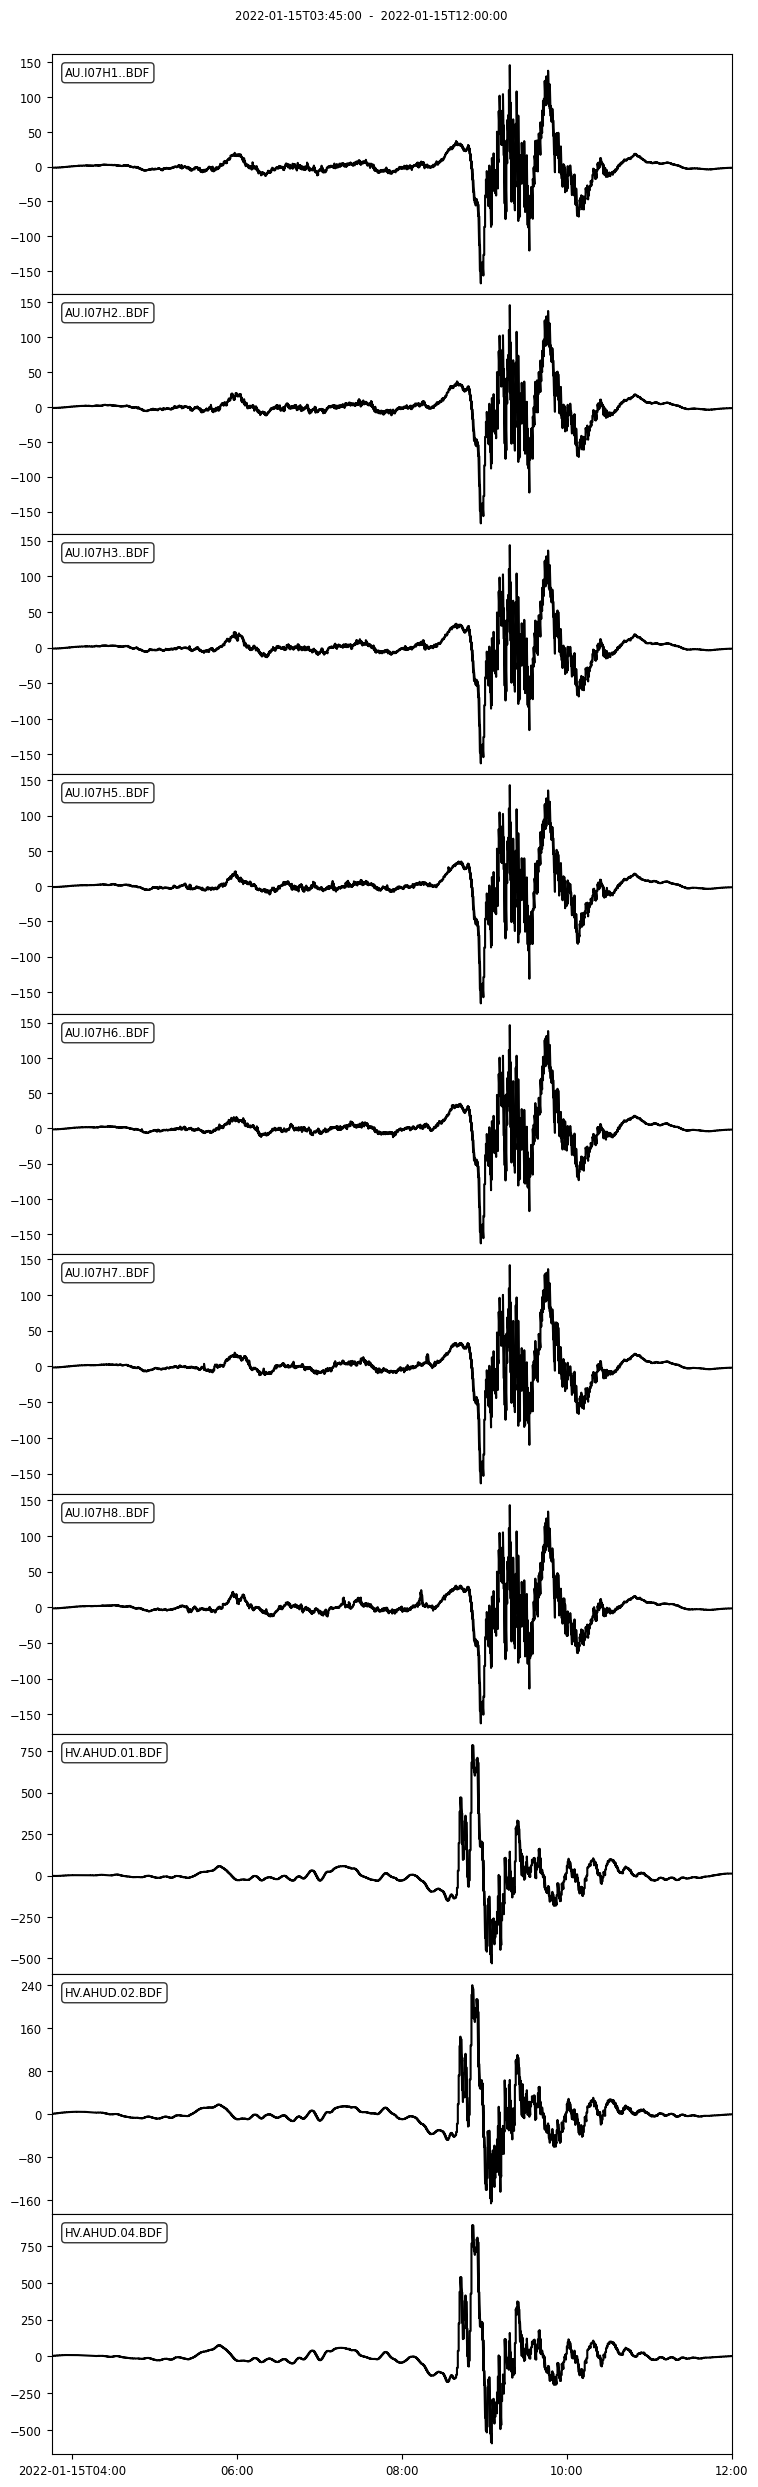

In [8]:
st_bdf[0:10].plot(equal_scale=False);

In [10]:
xmlfile = '/Users/thompsong/DATA/HungaTonga/STATIONXML/iris_BDF_within_80_degrees.xml'
inv_bdf = obspy.read_inventory(xmlfile)

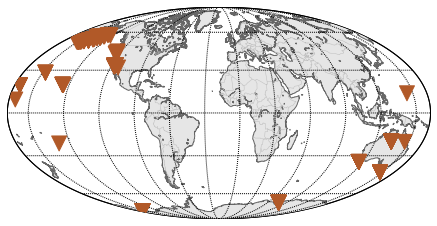

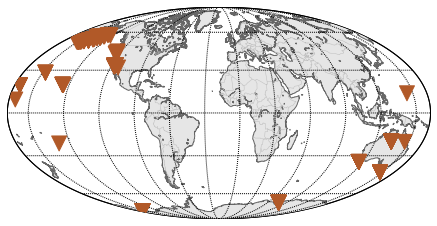

In [11]:
inv_bdf.plot()

In [24]:
libTonga.attach_station_coordinates_from_inventory(inv_bdf, st_bdf)
libTonga.attach_distance_to_stream(st_bdf, libTonga.sourcelat, libTonga.sourcelon)
r = np.array(libTonga.get_distance_vector(st_bdf))
st_bdf2 = libTonga.order_traces_by_distance(st_bdf, r)

In [ ]:
libTonga.attach_station_coordinates_from_inventory(inv_bdf, st_bdf)
libTonga.attach_distance_to_stream(st_bdf, libTonga.sourcelat, libTonga.sourcelon)
r = np.array(libTonga.get_distance_vector(st_bdf))
st_bdf2 = libTonga.order_traces_by_distance(st_bdf, r)

In [23]:
print(r)

[ 5225502.11719395  5225386.62695308  5225346.32233499  5226085.81740566
  5224584.78263447  5224360.87601723  5226024.28610957  4948849.40118834
  4948887.3009104   4948796.14230835  6424001.98980041  6425219.51093634
  6426789.52934526  6426209.89710379  6424950.80212369  6425393.55796302
  6425775.18679523  6425696.43753147  5424532.98429622  5424876.43279661
  5424903.52507253  5423784.47839093  4940742.70706267  4941602.94118722
  4941249.85716197  4939902.95907581  4843388.53925835  4845025.04511753
  4843834.68184935  4843443.59776422  4843103.79786621  4844452.96488672
  4844097.98307088  4844210.19783138  3991963.33264966  5768001.03023209
  1622781.19438744  4840749.84572304]


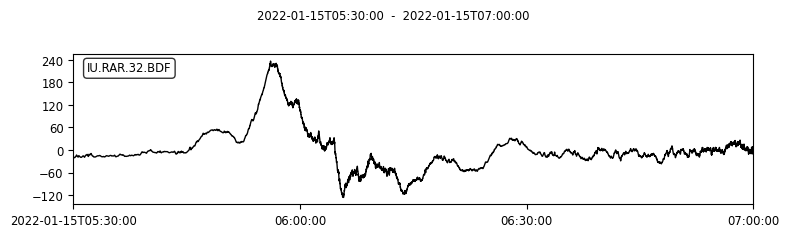

In [35]:
st_bdf2[0].plot(equal_scale=False, starttime=obspy.UTCDateTime(2022,1,15,5,30,0), endtime=obspy.UTCDateTime(2022,1,15,7,0,0) );

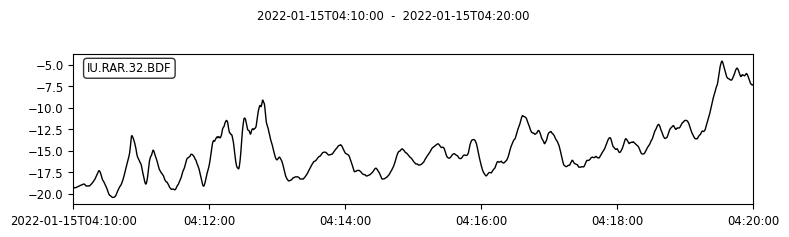

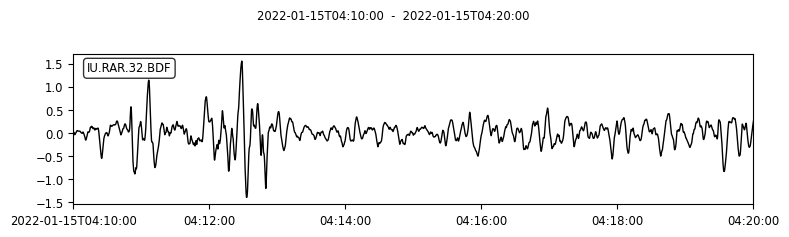

In [44]:
v = 340
stime = obspy.UTCDateTime(2022,1,15,4,10,0)
etime = obspy.UTCDateTime(2022,1,15,4,20,0)
rar = st_bdf2[0].copy()
rar.stats.starttime -= rar.stats.distance/v
rar.plot(equal_scale=False, starttime=stime, endtime=etime );
rar.filter('highpass', freq=0.1, corners=2)
rar.plot(equal_scale=False, starttime=stime, endtime=etime );


In [ ]:
fmin_infrasound = 0.0001
searchRadiusDeg_1Hz = 180
fdsnURL = "http://service.iris.edu"
startt_1Hz =  obspy.core.UTCDateTime('2022-01-13T00:00:00.000000Z') - (1.0/fmin_infrasound)*2
endt_1Hz = obspy.core.UTCDateTime('2022-01-20T00:00:00.000000Z') - (1.0/fmin_infrasound)*2